# Comparison of (penalized) Logistic Regression and K-Nearest-Neighbors (KNN) on MNIST digits

This mini project will compare the performance. characteristics, and implementations of the two commonly used classifiers, namely Logistic Regression and k-Nearest Neighbors. The data we will be working with are hand-written MNIST digit of 4s and 9s, represented as `28x28` pixel arrays. There will be two training sets: `mnist_train`, which contains 80 examples of each class, and `mnist_train_small`, which contains 5 examples of each class. There is also a validation set `mnist_valid` that we will use for model selection, and a test set `mnist_test` for the final testing.

## KNN Implementation

In [1]:
#setup
import numpy as np
import matplotlib.pyplot as plt
import math

Implement the function that computes the Euclidean distance matrix between the image $a$ and $b$.

In [2]:
def l2_distance(a, b):
    if a.shape[0] != b.shape[0]:
        raise ValueError("A and B should be of same dimensionality")
    aa = np.sum(a**2, axis=0)
    bb = np.sum(b**2, axis=0)
    ab = np.dot(a.T, b)
    return np.sqrt(aa[:, np.newaxis] + bb[np.newaxis, :] - 2*ab)

Load the MNIST digits datasets.

In [3]:
def load_train():
    """Loads training data."""
    with open('mnist_train.npz', 'rb') as f:
        train_set = np.load(f)
        train_inputs = train_set['train_inputs']
        train_targets = train_set['train_targets']
    return train_inputs, train_targets 

def load_train_small():
    """Loads small training data."""
    with open('mnist_train_small.npz', 'rb') as f:
        train_set_small = np.load(f)
        train_inputs_small = train_set_small['train_inputs_small']
        train_targets_small = train_set_small['train_targets_small']
    return train_inputs_small, train_targets_small

def load_valid():
    """Loads validation data."""
    with open('mnist_valid.npz', 'rb') as f:
        valid_set = np.load(f)
        valid_inputs = valid_set['valid_inputs']
        valid_targets = valid_set['valid_targets']
    return valid_inputs, valid_targets 

def load_test():
    """Loads test data."""
    with open('mnist_test.npz', 'rb') as f:
        test_set = np.load(f)
        test_inputs = test_set['test_inputs']
        test_targets = test_set['test_targets']
    return test_inputs, test_targets 

Implement `extract_digits` that returns a list of 28 x 28 pixel intensity arrays starting at `start_index` and ending at `end_index`.

In [4]:
def extract_digits(digit_array, start_index, end_index):
    digits = []
    for index in range(int(start_index), int(end_index)):
        digits.append(extract_digit_pixels(digit_array, index))
    return digits

Extracts the 28 x 28 pixel intensity array at the specified index.

In [5]:
def extract_digit_pixels(digit_array, index):
    return digit_array[index].reshape(28, 28)

Displays two rows of digits on the screen.

In [6]:
def show_pane(top_digits, bottom_digits):
    all_digits = top_digits + bottom_digits
    fig, axes = plt.subplots(nrows = 2, ncols = len(all_digits)//2)
    for axis, digit in zip(axes.reshape(-1), all_digits):
        axis.imshow(digit, interpolation='nearest', cmap=plt.gray())
        axis.axis('off')
    plt.show()

Implement the function `plot_digits` to visualizes each example in `digit_array`.

In [7]:
def plot_digits(digit_array):
    """
    Note: N is the number of examples 
          and M is the number of features per example.
    Inputs:
        digits: N x M array of pixel intensities.
    """
    CLASS_EXAMPLES_PER_PANE = 5

    # assume two evenly split classes
    examples_per_class = digit_array.shape[0]/2
    num_panes = int(np.ceil(float(examples_per_class)/CLASS_EXAMPLES_PER_PANE))

    for pane in range(num_panes):
        print("Displaying pane {}/{}".format(pane+1, num_panes))

        top_start = pane*CLASS_EXAMPLES_PER_PANE
        top_end = min((pane+1)*CLASS_EXAMPLES_PER_PANE, examples_per_class)
        top_pane_digits = extract_digits(digit_array, top_start, top_end)

        bottom_start = top_start + examples_per_class
        bottom_end = top_end + examples_per_class
        bottom_pane_digits = extract_digits(digit_array, bottom_start, bottom_end)
        show_pane(top_pane_digits, bottom_pane_digits)

Example of plotting a digit from `load_train_small`

Displaying pane 1/1


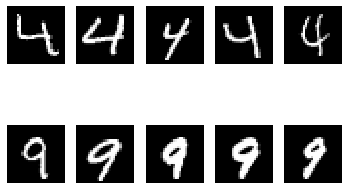

In [8]:
plot_digits(load_train_small()[0])

Corresponding lables of `load_train_small`

In [9]:
load_train_small()[1]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

## KNN Execution

Implement the main function for KNN, `run_knn` that uses the supplied training inputs and labels to make predictions for validation data using the K-nearest neighbours algorithm.

In [10]:
def run_knn(k, train_data, train_labels, valid_data):
    """
    Note: N_TRAIN is the number of training examples,
          N_VALID is the number of validation examples, 
          and M is the number of features per example.
    Inputs:
        k:            The number of neighbours to use for classification 
                      of a validation example.
        train_data:   The N_TRAIN x M array of training
                      data.
        train_labels: The N_TRAIN x 1 vector of training labels
                      corresponding to the examples in train_data 
                      (must be binary).
        valid_data:   The N_VALID x M array of data to
                      predict classes for.
    Outputs:
        valid_labels: The N_VALID x 1 vector of predicted labels 
                      for the validation data.
    """

    dist = l2_distance(valid_data.T, train_data.T)
    nearest = np.argsort(dist, axis=1)[:,:k]

    train_labels = train_labels.reshape(-1)
    valid_labels = train_labels[nearest]

    # note this only works for binary labels
    valid_labels = (np.mean(valid_labels, axis=1) >= 0.5).astype(np.int)
    valid_labels = valid_labels.reshape(-1,1)

    return valid_labels

We will now run `kNN` for different values of $k \in \{1, 3, 5, 7, 9\}$ and plot the classification rate on the validation set (number of correctly predicted cases, divided by total number of data points) as a function of `k`.

In [11]:
train_inputs, train_targets = load_train()
valid_inputs, valid_targets = load_valid()
test_inputs, test_targets = load_test()

set_k = [1,3,5,7,9]

accuracy_valid_output = {}
accuracy_test_output = {}

length_valid = len(valid_inputs)
length_test = len(test_inputs)
for k in set_k:
    valid_outputs = run_knn(k, train_inputs, train_targets, valid_inputs)
    test_outputs =  run_knn(k, train_inputs, train_targets, test_inputs)

    count_valid = np.sum(valid_outputs == valid_targets) 
    accuracy_valid = count_valid/length_valid
    accuracy_valid_output["k="+str(k)] = accuracy_valid

    count_test = np.sum(test_outputs == test_targets) 
    accuracy_test = count_test/length_test
    accuracy_test_output["k="+str(k)] = accuracy_test

Validation Accuracy:

In [12]:
accuracy_valid_output

{'k=1': 0.82, 'k=3': 0.86, 'k=5': 0.86, 'k=7': 0.86, 'k=9': 0.84}

Test Accuracy:

In [13]:
accuracy_test_output

{'k=1': 0.88, 'k=3': 0.92, 'k=5': 0.94, 'k=7': 0.94, 'k=9': 0.88}

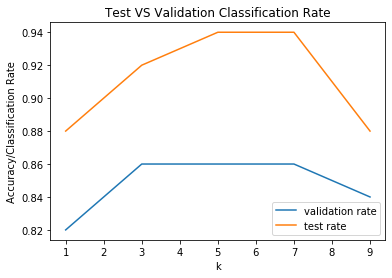

In [14]:
plt.plot(set_k, list(accuracy_valid_output.values()), label="validation rate")
plt.plot(set_k, list(accuracy_test_output.values()), label="test rate")

plt.title("Test VS Validation Classification Rate")
plt.xlabel("k")
plt.ylabel("Accuracy/Classification Rate")
plt.legend()
plt.savefig("Test Set VS Validation Rates of KNN.png")

### Comments on the performance and which value of k* to choose from:

Although the $k$ value of $5$ and $7$ has the same classification rate for both test and validation data set, I would choose $k^*$ to be $5$. This is because having choosing $k^* = 5$, $k^*-2 = 3$ and $k^*+2 = 7$ also outputs the highest classification rate (for both test and validation) compared to all other values for $k^*$. This might suggest that this value of $k^*$ would also perform better in different data sets (as shown by the figure above).

However, the classification rate for validation and test set does not correspond, for example, for $k=3$ and $k=5$, they both have the classification rate of $0.86$ on validation set, the performance on test set is $0.92$ and $0.94$, respectively. This is likely to be caused by the different labelled data set provided to training and validation data (since both their sample size is 50 while the sample size for training set is 160). This causes the classification rate for test set to be consistently higher than that of all validation set.

# Logisitic Regression and penalized Logisitic Regression

Now, we will perform the experiment with the same MNIST datasets of 4's and 9's using logisitic regression and penalized logisitic regression on both `mnist_train` and `mnist_train_small` datasets, and attempt to choose the best hyperparameters for the `learning rate`, the `number of iterations`, and the way in which we initialize the `weights`.

## Definition

We will define a single digit in our dataset as a $D$-dimensional data vector $x = (x_1, . . . , x_D)^T$ and its associated class variable $t \in \{0, 1\}$which is Bernoulli random variable with parameter $\alpha$ (i.e. $P(t = 1) = \alpha$ and $P(t = 0) = 1 − \alpha$). Since, we are working with binary classification (with 4's and 9's digits), we can simply let $t=1$ be labelled as digit "4" and $t=0$ be digit "9". Now, for our classification problem, we can assume that the dimensions of $x$ are conditionally independent given $t$, and that the conditional distribution of each $x_i$ is Gaussian with $\mu_{i0}$ and $\mu_{i1}$ as the means of the two classes and $\sigma_i$ as their shared standard deviation, i.e. $x_i|t \sim  N(\mu_{it}, \sigma_i^2 )$. 

### By Bayes' Rule

Hence, by Bayes' Rule, we can define,
$$\begin{align*}
p(t = 1|\mathbf{x}) &= \frac{P(x|t=1) P(t=1)}{P(x)} \\
\end{align*}$$
and since $x_i$'s are conditionally independent, we can re-write,
\begin{align*}
    P(x|t=1) &= \prod_{i=1}^{D}\frac{1}{\sqrt{2\pi}\sigma_i}exp(-(\frac{(x_i-\mu_{i1})^2}{2{\sigma_i}^2}))
\end{align*}
\begin{align*}
    P(x|t=0) &= \prod_{i=1}^{D}\frac{1}{\sqrt{2\pi}\sigma_i}exp(-(\frac{(x_i-\mu_{i0})^2}{2{\sigma_i}^2}))
\end{align*}
Also, since $t \sim Ber(\alpha)$, then,
\begin{align*}
    P(x) &= P(x|t=0)P(t=0) + P(x|t=1)P(t=1)\\
    &=  \prod_{i=1}^{D}\frac{1}{\sqrt{2\pi}\sigma_i}exp(-(\frac{(x_i-\mu_{i0})^2}{2{\sigma_i}^2})) \times (1-\alpha) +  \prod_{i=1}^{D}\frac{1}{\sqrt{2\pi}\sigma_i}exp(-(\frac{(x_i-\mu_{i1})^2}{2{\sigma_i}^2})) \times \alpha
\end{align*}
So, we can finally re-write $p(t = 1|\mathbf{x})$ as
\begin{align*}
    P(t=1|x) &= \frac{\prod_{i=1}^{D}\frac{1}{\sqrt{2\pi}\sigma_i}exp(-(\frac{(x_i-\mu_{i1})^2}{2{\sigma_i}^2})) \times \alpha}{\prod_{i=1}^{D}\frac{1}{\sqrt{2\pi}\sigma_i}exp(-(\frac{(x_i-\mu_{i0})^2}{2{\sigma_i}^2})) \times (1-\alpha) +  \prod_{i=1}^{D}\frac{1}{\sqrt{2\pi}\sigma_i}exp(-(\frac{(x_i-\mu_{i1})^2}{2{\sigma_i}^2})) \times \alpha} \\
    &= \frac{\prod_{i=1}^{D}exp(-(\frac{(x_i-\mu_{i0})^2}{2{\sigma_i}^2})) \times (1-\alpha)} {\prod_{i=1}^{D}exp(-(\frac{(x_i-\mu_{i1})^2}{2{\sigma_i}^2})) \times \alpha} \\
    &= \frac{1-\alpha}{\alpha} exp(-\sum_{i=1}^{D}\frac{(x_i-\mu_{i0})^2 - (x_i-\mu_{i1})^2 }{2\sigma^2})\\
    &= exp(-\sum_{i=1}^{D}\frac{-\mu_{i0} +\mu_{i1}}{\sigma^2}x_i + (-\sum_{i=1}^{D}(\frac{\mu_{i0}^2  - \mu_{i1} ^2  }{2\sigma^2}) + \ln(\frac{1-\alpha}{\alpha})) \\
\end{align*}


By substituting $w_i = -\sum_{i=1}^{D}\frac{-\mu_{i0} +\mu_{i1}}{\sigma^2}$ as our weights $(w_1, . . . , w_D)^T$ and $b = \sum_{i=1}^{D}(\frac{\mu_{i0}^2  - \mu_{i1} ^2  }{2\sigma^2}) - \ln(\frac{1-\alpha}{\alpha})$ as our bias, we can re-write:


$$\begin{align*}
    P(t=1|\mathbf{x})  &= \frac{1}{1+exp(-\sum_{i=1}^{D}w_ix_i-b)}\\
    &= \sigma(w^Tx+b)
\end{align*}$$

### Deriving the loss function using Maximum Likelihood Estimation

Now, our whole training, testing, and validation sets can de defined as $D = \{(\boldsymbol{x}^{(1)}, t^{(1)} ), ...,(\boldsymbol{x}^{(N)}, t^{(N)} )\} $, where $N$ is the number of digits in each set. So our dervied binary logistic regression classifier will be
$$
\begin{align*}
    p(t^{(n)}=1|\boldsymbol{x}^{(n)}, \boldsymbol{w}, b) &= \sigma(\boldsymbol{w}^T\boldsymbol{x}^{(n)}+b)\\
    &= \frac{1}{1+exp(-\sum_{i=1}^{D}w_ix_i^{(n)}-b)}
\end{align*}
$$

By definition of the likelihood function, we know
$$
\begin{align*}
    L(t_i| w, b) = \prod_{i=1}^{n}f(t_i| w, b)\\
\end{align*}$$
where $p(t_i) = p(t=1|x_i)^{t_i} \times p(t=0|x_i)^{1-t_i}$

Hence, our loss function $L(\boldsymbol{w}, b)$ or the `negative log-likelihood` of $t^{(1)}, ..., t^{(n)}$ given $\boldsymbol{x}^{(1)}, ..., \boldsymbol{x}^{(n)}$ can be defined as:
$$
\begin{align*}
    L(w,b) &= -\log{L(t_i| w, b)}\\
    &= -\log(\prod_{i=1}^{n}( p(t^{(i)}=1|\boldsymbol{x}^{(n)}, \boldsymbol{w}, b)^{t^{(i)}})    p(t^{(i)}=0|\boldsymbol{x}^{(n)}, \boldsymbol{w}, b)^{1-t^{(i)}}) )\\
    &= \sum_{i=1}^{n}-t^{(i)} \log  \sigma(\boldsymbol{w}^T\boldsymbol{x}^{(n)}+b) -(1-t^{(i)}) \log   (1-\sigma(\boldsymbol{w}^T\boldsymbol{x}^{(n)}+b))
\end{align*}
$$
we then can denote $\sigma(\boldsymbol{w}^T\boldsymbol{x}^{(i)}+b)$ as our prediction value $y^{(i)}$ to get the final binary cross entropy loss as:
$$
L(w,b) = \sum_{i=1}^{n}-t^{(i)} \log y^{(i)}  - (1-t^{(i)})\log (1-y^{(i)})
$$


Finally, taking derivatives with respect to each paramater (weights and bias), we will get
$$
    \frac{\partial L}{\partial w} = \sum_{i=1}^{n}x^{(n)}  (y^{(i)}-t^{(i)}))
$$
and
$$
    \frac{\partial L}{\partial b} = \sum_{i=1}^{n}  (y^{(i)}-t^{(i)})
$$

### L2 Regularization for Penalized Logisitic Regression

Now, we treat $\boldsymbol{x}^{(i)}$'s as deterministic and assume that a Gaussian prior is placed on each element of $\boldsymbol{w}$ such that $p(w_i) = N(w_i|0, 1/\lambda)$, i.e.,
$$
\begin{align*}
    p(w_i) &= \frac{1}{\sqrt{2\pi (\frac{1}{\lambda})}}exp(\frac{-(w_i-0)^2}{2\frac{1}{\lambda}})\\
    &=  \frac{1}{\sqrt{2\pi (\frac{1}{\lambda})}}exp(\frac{-w{_i}^2 \lambda}{2})
\end{align*}
$$ and also place an “improper” flat
prior on $b$ such that $p(b) = 1$.

Then the posterior distribution for $\boldsymbol{w}$ and $b$ is proportional to the product of this prior and the likelihood of  $t^{(1)}, ..., t^{(n)}$:
$$
\begin{align*}
p(\boldsymbol{w}, b|t^{(1)}, ..., t^{(n)}) &\propto p(\boldsymbol{w})p(b)p(t^{(1)}, ..., t^{(n)}|\boldsymbol{w},b)\\
&= \prod_{i=1}^{D}(\sqrt{\frac{\lambda}{2\pi}} exp(-\frac{\lambda w_i^2}{2})        ) p(t^{(1)}, ..., t^{(n)}|\boldsymbol{w},b)\\
\end{align*}
$$



Hence, we will define the new loss function $L_{post}(\boldsymbol{w},b)$ as the negative logarithm of this posterior.
$$
\begin{align*}
p(\boldsymbol{w}, b|t^{(1)}, ..., t^{(n)}) &\propto p(\boldsymbol{w})p(b)p(t^{(1)}, ..., t^{(n)}|\boldsymbol{w},b)\\
&= -\log\left(\left(\prod_{i=1}^{D}\sqrt{\frac{\lambda}{2\pi}} exp(-\frac{\lambda w_i^2}{2}\right)      p(t^{(1)}, ..., t^{(n)}|\boldsymbol{w},b)\right)\\
&= -\sum_{i=1}^{D} \log \sqrt{\frac{\lambda}{2\pi}} + \frac{\lambda}{2}\sum_{i=1}^{D}w{_i}^2 + L(\boldsymbol{w}, b)\\
&= L(\boldsymbol{w}, b) + \frac{\lambda}{2}\sum_{i=1}^{D}w_{i}^2 + c
\end{align*}
$$
, where the constant $c =  -\sum_{i=1}^{D} \log \sqrt{\frac{\lambda}{2\pi}}$ 

Finally, taking derivatives with respect to each paramater (weights and bias), we will get
$$
\begin{align*}
    \frac{\partial L_{post}}{\partial w} &= \frac{\partial L}{\partial w} + \frac{\lambda}{2}2w\\
    &= \sum_{i=1}^{n}x^{(n)}  (y^{(i)}-t^{(i)})) + \lambda w
\end{align*}
$$
and
$$
\begin{align*}
    \frac{\partial L_{post}}{\partial b} &= \frac{\partial L}{\partial b}\\
    &= \sum_{i=1}^{n} (y^{(i)}-t^{(i)})
\end{align*}
$$

## Implementation

We can then use these derivations to implement the logisitic and penalized logisitic regression algorithms for classifying the 4's and 9's digits

First, we will compute the element wise logistic sigmoid of $x$.

In [15]:
def sigmoid(x):
    """
    Inputs:
        x: Either a row vector or a column vector.
    """
    return 1.0 / (1.0 + np.exp(-x))

Then, implement the `logistic_predict` function to compute the probabilities predicted by the logistic classifier.

In [16]:
def logistic_predict(weights, data):
    """
    Note: N is the number of examples and
          M is the number of features per example.

    Inputs:
        weights:    (M+1) x 1 vector of weights, where the last element
                    corresponds to the bias (intercepts).
        data:       N x M data matrix where each row corresponds
                    to one data point.
    Outputs:
        y:          :N x 1 vector of probabilities. This is the output of the classifier.
    """
    b = weights[-1]
    y = sigmoid(np.dot(data, weights[:-1]) + b)
    return y

Compute evaluation metrics.

In [17]:
def evaluate(targets, y):
    """
    Inputs:
        targets : N x 1 vector of targets.
        y       : N x 1 vector of probabilities.
    Outputs:
        ce           : (scalar) Cross entropy. CE(p, q) = E_p[-log q]. Here we want to compute CE(targets, y)
        frac_correct : (scalar) Fraction of inputs classified correctly.
    """
    ce = - np.dot(np.transpose(targets), np.log(y)) #
    frac_correct = (targets == (y > 0.5)).mean()  #
    return ce, frac_correct

Calculate negative log likelihood and its derivatives with respect to weights and also return the predictions.

In [308]:
def logistic(weights, data, targets, hyperparameters):
    """
    Note: N is the number of examples and
          M is the number of features per example.
    Inputs:
        weights:    (M+1) x 1 vector of weights, where the last element
                    corresponds to bias (intercepts).
        data:       N x M data matrix where each row corresponds
                    to one data point.
        targets:    N x 1 vector of targets class probabilities.
        hyperparameters: The hyperparameters dictionary.
    Outputs:
        f:       The sum of the loss over all data points. This is the objective that we want to minimize.
        df:      (M+1) x 1 vector of derivative of f w.r.t. weights.
        y:       N x 1 vector of probabilities.
    """  
    y = logistic_predict(weights, data) #after sigmoid transformation
    #compute f and df without regularization
    f = 0
    for i in range(len(y)): #y is vector of n elements
        f += (-targets[i]*math.log(y[i])) - (1-targets[i])*math.log(1-y[i]) #by formula of L_CE
        
    product = data.T.dot(y-targets)
    #add vector of sum([y-targets]) to the last row to make df to size (M+1) x 1
    df = np.append(product, [[np.sum(y-targets)]], axis = 0) 
    
# Implementatation using np matrices
#     y = logistic_predict(weights, data)
#     f = (-np.matmul(np.transpose(targets), np.log(y)) + \
#         - np.matmul(np.transpose(1-targets), np.log(1-y))) #c
#     df = np.transpose(np.matmul(np.transpose(y-targets), data)) #dJ/dw_i
#     db = np.array([[(y-targets).sum()]]) #dJ/db
#     df = np.concatenate((df,db))
    
    return f, df, y

Perform a simple gradient check on the implemented logistic function by using approximations

In [19]:
def check_grad(func, X, epsilon, *args):
    """
    checks the derivatives in a function, by comparing them to finite
    differences approximations. The partial derivatives and the approximation
    are printed and the norm of the diffrence divided by the norm of the sum is
    returned as an indication of accuracy.
    usage: checkgrad(func, X, epsilon, P1, P2, ...)
    where X is the argument and epsilon is the small perturbation used for the finite
    differences. and the P1, P2, ... are optional additional parameters which
    get passed to f. The function f should be of the type
    (fX, dfX) = func(X, P1, P2, ...)
    where fX is the function value and dfX is a vector of partial derivatives.
    Original Author: Carl Edward Rasmussen, 2001-08-01.
    Ported to Python 2.7 by JCS (9/21/2013).
    """
    if len(X.shape) != 2 or X.shape[1] != 1:
        raise ValueError("X must be a vector")
    y, dy, = func(X, *args)[:2]         # get the partial derivatives dy
    dh = np.zeros((len(X), 1))
    for j in range(len(X)):
        dx = np.zeros((len(X), 1))
        dx[j] += epsilon
        y2 = func(X+dx, *args)[0]
        dx = -dx
        y1 = func(X+dx, *args)[0]
        dh[j] = (y2 - y1)/(2*epsilon)
#     print(np.hstack((dy, dh)))         # print the two vectors
    d = np.linalg.norm(dh-dy)/np.linalg.norm(dh+dy)  # return norm of diff divided by norm of sum
    return d

def run_check_grad(hyperparameters):
    # This creates small random data with 20 examples and
    # 10 dimensions and checks the gradient on that data.
    num_examples = 20
    num_dimensions = 10
    weights = np.random.randn(num_dimensions+1, 1)
    data    = np.random.randn(num_examples, num_dimensions)
    targets = np.random.rand(num_examples, 1)

    diff = check_grad(logistic,      # function to check
                      weights,
                      0.001,         # perturbation
                      data,
                      targets,
                      hyperparameters)
    print("check_grad diff (should be close to 0)=", diff)

Implement `logistic_pen` function which accounts for `weight_regularization` ($\lambda$) as a hyperparameter. This $L2$ regularization model can be re-written as $$ L_{post}(w,b) = L(w,b) + \frac{\lambda}{2}\sum_{i=1}^{D}w_{i}^2 + C$$, where $C = -\frac{D}{2}\log \frac{\lambda}{2\pi}$.

In [309]:
def logistic_pen(weights, data, targets, hyperparameters):
    """
    Calculate negative log likelihood and its derivatives with respect to weights.
    Return the predictions.
    Note: N is the number of examples and
          M is the number of features per example.
    Inputs:
        weights:    (M+1) x 1 vector of weights, where the last element
                    corresponds to bias (intercepts).
        data:       N x M data matrix where each row corresponds
                    to one data point.
        targets:    N x 1 vector of targets class probabilities.
        hyperparameters: The hyperparameters dictionary.
    Outputs:
        f:             The sum of the loss over all data points. This is the objective that we want to minimize.
        df:            (M+1) x 1 vector of derivative of f w.r.t. weights.
    """
# Implementatation using np matrices
#     y = logistic_predict(weights, data)
#     lambd = hyperparameters['weight_regularization'] 
#     f = (-np.matmul(np.transpose(targets), np.log(y)) + \
#         - np.matmul(np.transpose(1-targets), np.log(1-y))) + lambd/2*(weights[:-1]**2).sum()
    
#     df = np.transpose(np.matmul(np.transpose(y-targets), data)) + lambd*weights[:-1] #dJ/dw_i
#     db = np.array([[(y-targets).sum()]]) #dJ/db
#     df = np.concatenate((df,db))
                                                                                                                                           
    w = weights[:-1] #removed bias for weights vector (last element)
    w1 = np.append(w, [[0]], axis=0) #added 0 to match the required M+1 dimension
    f, df, y = logistic(weights, data, targets, hyperparameters) #using logistic()
    
    #regulariizer term = scaled_lambda * (sum of weights^2)
    scaled_lambda = hyperparameters['weight_regularization'] / 2

    f = f + sum(((w1) ** 2) * scaled_lambda) #added regularizer term
    df = df + w1 * hyperparameters['weight_regularization'] #added regularizer term
    
    return f, df, y

## Execution

In [191]:
def run_logistic_regression(learning_rate, num_iterations, weight_regularization=None, stats_on=True, dataset="normal"):
    if dataset=="normal":
        train_inputs, train_targets = load_train()
    else: #dataset is "small"
        train_inputs, train_targets = load_train_small()
    valid_inputs, valid_targets = load_valid()
    test_inputs, test_targets = load_test()
    
    N, M = train_inputs.shape

    # Set hyperparameters
    hyperparameters = {
                    'learning_rate': learning_rate,
                    'weight_regularization': weight_regularization,
                    'num_iterations':num_iterations
                 }

    # Logistic regression weights
    # Initialize to random weights here.
    weights = np.random.randn(M + 1, 1) /10

    # Verify that your logistic function produces the right gradient.
    # diff should be very close to 0.
    run_check_grad(hyperparameters)

    ce_train = []
    ce_valid = []
    fc_train = []
    fc_valid = []

    # Begin learning with gradient descent
    for t in range(hyperparameters['num_iterations']):

        # Find the negative log likelihood and its derivatives w.r.t. the weights.
        if not weight_regularization:
            f, df, predictions = logistic(weights, train_inputs, train_targets, hyperparameters)
        else:
            f, df, predictions = logistic_pen(weights, train_inputs, train_targets, hyperparameters)

        # Evaluate the prediction.
        cross_entropy_train, frac_correct_train = evaluate(train_targets, predictions)

        if np.isnan(f) or np.isinf(f):
            raise ValueError("nan/inf error")

        # update parameters
        weights = weights - hyperparameters['learning_rate'] * df / N

        # Make a prediction on the valid_inputs.
        predictions_valid = logistic_predict(weights, valid_inputs)

        # Evaluate the prediction.
        cross_entropy_valid, frac_correct_valid = evaluate(valid_targets, predictions_valid)

        # print stats if stats_on is True
        if stats_on:
            print(("ITERATION:{:4d}  TRAIN NLOGL:{:4.2f}  TRAIN CE:{:.6f} "
                   "TRAIN FRAC:{:2.2f}  VALID CE:{:.6f}  VALID FRAC:{:2.2f}").format(
                       (t+1), float(f / N), float(cross_entropy_train), float(frac_correct_train*100),
                       float(cross_entropy_valid), float(frac_correct_valid*100)))

        ce_train = np.append(ce_train, cross_entropy_train)
        ce_valid = np.append(ce_valid, cross_entropy_valid)
        fc_train = np.append(fc_train, frac_correct_train)
        fc_valid = np.append(fc_valid, frac_correct_valid)

    plt.plot(ce_train, label = "training set")
    plt.plot(ce_valid, label = "validation set")
    plt.title("Cross Entropy with small training set using \n learning rate "+ str(hyperparameters['learning_rate'])+
              " and " + str(hyperparameters['num_iterations']) + " iterations and lambda penalty of "+
              str(hyperparameters['weight_regularization']))
    plt.legend()
    plt.show()
    
    plt.plot(fc_train, label = "training set")
    plt.plot(fc_valid, label = "validation set")
    plt.legend()
    plt.title("Fraction Correctness with small training set using \n learning rate "+ str(hyperparameters['learning_rate'])+
          " and " + str(hyperparameters['num_iterations'])+ " iterations and lambda penalty of "+
              str(hyperparameters['weight_regularization']))
    plt.show()
    
    #predict test_input
    predictions_test = logistic_predict(weights, test_inputs)
    cross_entropy_test, frac_correct_test = evaluate(test_targets, predictions_test)
    print("FINAL TEST FRAC:{:2.2f}".format(frac_correct_test * 100))

Now, we will experiment with different hyperparameters of `learning_rate`, `num_iterations`,`weight_regularization`, and `dataset` size to determine which sets of hyperparameters are performing the best under different settings.

### Experiment1: learning_rate=0.01, num_iterations=100, weight_regularization=None, stats_on=True, dataset="normal"

First, we will experiment with the above settings as a baseline model and visualize the detailed training process of each iterations (since there are only 100 iterations) on the default dataset. 

check_grad diff (should be close to 0)= 2.5245581206509907e-08
ITERATION:   1  TRAIN NLOGL:-147.13  TRAIN CE:92.506182 TRAIN FRAC:37.50  VALID CE:29.230370  VALID FRAC:48.00
ITERATION:   2  TRAIN NLOGL:-141.59  TRAIN CE:89.037313 TRAIN FRAC:38.75  VALID CE:28.221884  VALID FRAC:48.00
ITERATION:   3  TRAIN NLOGL:-136.55  TRAIN CE:85.874398 TRAIN FRAC:39.38  VALID CE:27.302318  VALID FRAC:48.00
ITERATION:   4  TRAIN NLOGL:-131.94  TRAIN CE:82.988844 TRAIN FRAC:40.00  VALID CE:26.463218  VALID FRAC:48.00
ITERATION:   5  TRAIN NLOGL:-127.74  TRAIN CE:80.354083 TRAIN FRAC:40.00  VALID CE:25.696788  VALID FRAC:50.00
ITERATION:   6  TRAIN NLOGL:-123.90  TRAIN CE:77.945640 TRAIN FRAC:40.62  VALID CE:24.995892  VALID FRAC:50.00
ITERATION:   7  TRAIN NLOGL:-120.38  TRAIN CE:75.741127 TRAIN FRAC:41.25  VALID CE:24.354028  VALID FRAC:50.00
ITERATION:   8  TRAIN NLOGL:-117.15  TRAIN CE:73.720180 TRAIN FRAC:40.62  VALID CE:23.765303  VALID FRAC:52.00
ITERATION:   9  TRAIN NLOGL:-114.19  TRAIN CE:71.

ITERATION:  75  TRAIN NLOGL:-61.66  TRAIN CE:38.848368 TRAIN FRAC:84.38  VALID CE:13.506614  VALID FRAC:76.00
ITERATION:  76  TRAIN NLOGL:-61.35  TRAIN CE:38.653930 TRAIN FRAC:84.38  VALID CE:13.447354  VALID FRAC:76.00
ITERATION:  77  TRAIN NLOGL:-61.04  TRAIN CE:38.462112 TRAIN FRAC:85.00  VALID CE:13.388832  VALID FRAC:76.00
ITERATION:  78  TRAIN NLOGL:-60.74  TRAIN CE:38.272856 TRAIN FRAC:85.00  VALID CE:13.331033  VALID FRAC:76.00
ITERATION:  79  TRAIN NLOGL:-60.45  TRAIN CE:38.086108 TRAIN FRAC:85.00  VALID CE:13.273942  VALID FRAC:76.00
ITERATION:  80  TRAIN NLOGL:-60.15  TRAIN CE:37.901813 TRAIN FRAC:85.00  VALID CE:13.217544  VALID FRAC:76.00
ITERATION:  81  TRAIN NLOGL:-59.86  TRAIN CE:37.719921 TRAIN FRAC:85.62  VALID CE:13.161826  VALID FRAC:76.00
ITERATION:  82  TRAIN NLOGL:-59.58  TRAIN CE:37.540381 TRAIN FRAC:85.62  VALID CE:13.106773  VALID FRAC:76.00
ITERATION:  83  TRAIN NLOGL:-59.30  TRAIN CE:37.363146 TRAIN FRAC:85.62  VALID CE:13.052373  VALID FRAC:76.00
ITERATION:

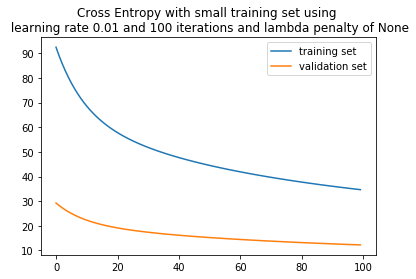

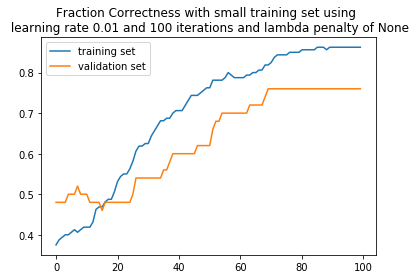

FINAL TEST FRAC:82.00


In [250]:
run_logistic_regression(learning_rate=0.01, num_iterations=100, weight_regularization=None, stats_on=True, dataset="normal")

### Experiment2: learning_rate=0.01, num_iterations=100, weight_regularization=0.1, stats_on=False, dataset="normal"

Now, we will experiment with the exact same settings, but with weight_regularization set to 0.1 to test our penalized logisitc model.

check_grad diff (should be close to 0)= 4.8983302070995694e-08


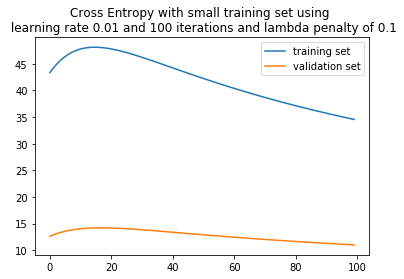

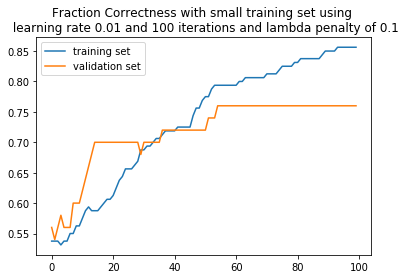

FINAL TEST FRAC:88.00


In [254]:
run_logistic_regression(learning_rate=0.01, num_iterations=100, weight_regularization=0.1, stats_on=False, dataset="normal")

We can see that the final test score (on the testing data set) is slightly better than our baseline model with a higher 6% accuracy. However, since our number of iterations is only 100, the difference might be due to the random initialization of weights. Hence, we will increase the number of iterations as follows.

### Experiment3: learning_rate=0.01, num_iterations=10000, weight_regularization=None, stats_on=False, dataset="normal"

check_grad diff (should be close to 0)= 3.202069888691553e-08


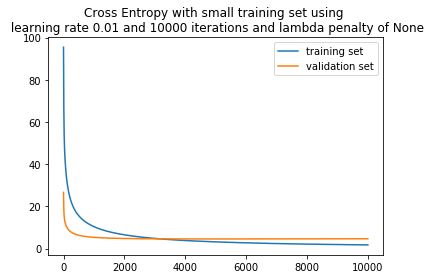

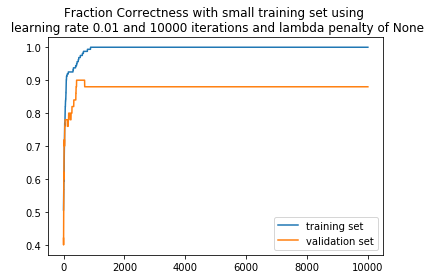

FINAL TEST FRAC:92.00


In [257]:
run_logistic_regression(learning_rate=0.01, num_iterations=10000, weight_regularization=None, stats_on=False, dataset="normal")

### Experiment4: learning_rate=0.01, num_iterations=10000, weight_regularization=0.1, stats_on=False, dataset="normal"

check_grad diff (should be close to 0)= 2.0148717799918903e-08


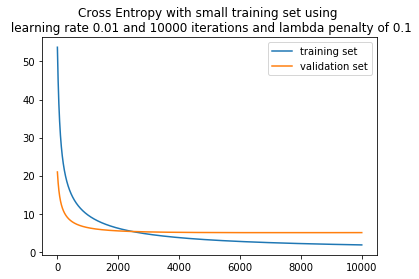

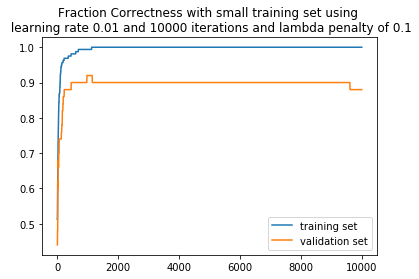

FINAL TEST FRAC:92.00


In [256]:
run_logistic_regression(learning_rate=0.01, num_iterations=10000, weight_regularization=0.1, stats_on=False, dataset="normal")

Based on Experiments 3 and 4, we can see that when we increase our iterations number to 10000, both logisitic regression and its penalized version performed the same, with an accuracy of 92% on the testing sets. However, there seems to be an issue of overfitting on the training set at around 2000 iteration (since the training accuracy has remained at 100%). We will further demonstrate this issue of overfitting using a smaller number of iterations (since higher number of iterations on both penalized and default logisitic models will both result in strong overfitting), but moving to the `smaller` dataset.

### Experiment5: learning_rate=0.01, num_iterations=500, weight_regularization=None, stats_on=False, dataset="small"

check_grad diff (should be close to 0)= 2.6299493242162578e-08


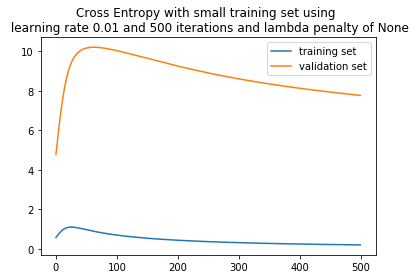

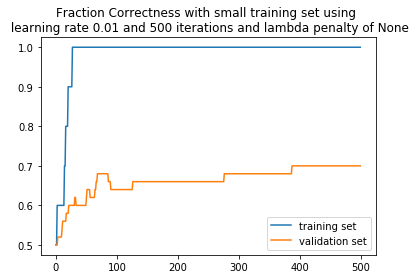

FINAL TEST FRAC:72.00


In [247]:
run_logistic_regression(learning_rate=0.01, num_iterations=500, weight_regularization=None, stats_on=False, dataset="small")

### Experiment6: learning_rate=0.01, num_iterations=500, weight_regularization=1, stats_on=False, dataset="small"

check_grad diff (should be close to 0)= 1.937067785310409e-08


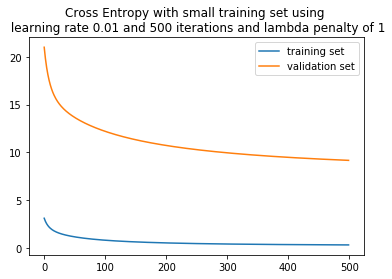

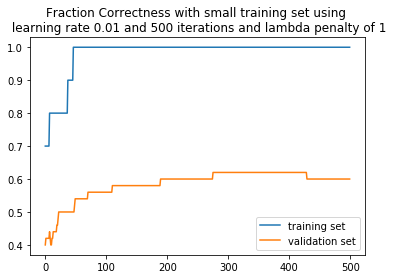

FINAL TEST FRAC:76.00


In [248]:
run_logistic_regression(learning_rate=0.01, num_iterations=500, weight_regularization=1, stats_on=False, dataset="small")

Based on Experiments 5 and 6, we can see that when we set a high $\lambda$ value of $1$ for the penalized logisitic regression model, we have performed slighly better in terms of final testing accuracy. This is also reflected on the accuracy graph, where the default logisitic regression model's training accuracy increases steeply and vertically, but the regularization model has a staircase-like increase in the training accuracy. This is mainly because of `L2 Regularization` we used in the penalized model, as a higher $\lambda$ value adds a higher penalty parameter, which in turns penalizes higher order coefficients and results in a "simpler" model (to avoid overfitting).